# Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd
import transformers
import datasets
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
from PIL import Image

2024-11-22 22:43:41.099863: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 22:43:41.550432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 22:43:42.568231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

2024-11-22 22:43:46.688239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 22:43:46.694923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 22:43:46.694961: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [3]:
dataset = datasets.load_dataset("Bingsu/Gameplay_Images")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Among Us', 'Apex Legends', 'Fortnite', 'Forza Horizon', 'Free Fire', 'Genshin Impact', 'God of War', 'Minecraft', 'Roblox', 'Terraria'], id=None)}

In [6]:
dataset['train'][600]['image']

In [13]:
np.array(dataset['train'][600]['image']).shape

(360, 640, 4)

In [8]:
labels = {
    "Among Us": 0,
    "Apex Legends": 1,
    "Fortnite": 2,
    "Forza Horizon": 3,
    "Free Fire": 4,
    "Genshin Impact": 5,
    "God of War": 6,
    "Minecraft": 7,
    "Roblox": 8,
    "Terraria": 9
}

In [22]:
dataset['train'].features['label'].names

['Among Us',
 'Apex Legends',
 'Fortnite',
 'Forza Horizon',
 'Free Fire',
 'Genshin Impact',
 'God of War',
 'Minecraft',
 'Roblox',
 'Terraria']

In [20]:
dataset['train'][999]['label']

0

In [23]:
output_dir = 'gameplay_images'
os.makedirs(output_dir, exist_ok=True)

for label in dataset['train'].features['label'].names:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)


def save_images(object_, idx):
    image = object_['image']
    label = dataset['train'].features['label'].names[object_['label']]
    image_path = os.path.join(output_dir, label, f"{idx}.jpg")
    image = image.convert('RGB')
    image.save(image_path)
    return object_

dataset['train'].map(save_images, with_indices=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [3]:
backbone = transformers.AutoModel.from_pretrained('facebook/dinov2-small')

Load tokenizer to be used with the model

In [4]:
processor = transformers.AutoImageProcessor.from_pretrained('facebook/dinov2-small')

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [8]:
data_dir = 'gameplay_images/Genshin Impact/'


image_file = '5000.jpg'

images = []

image_path = os.path.join(data_dir, image_file)
image = Image.open(image_path).convert('RGB')
images.append(image)

In [9]:
images

[<PIL.Image.Image image mode=RGB size=640x360>]

In [33]:
inputs = processor(images=images, return_tensors="pt")

In [34]:
inputs

{'pixel_values': tensor([[[[ 2.1119,  2.1804,  1.8208,  ...,  2.1290,  2.1290,  2.1462],
          [ 2.2489,  2.2489,  0.9474,  ...,  2.1462,  2.1462,  2.1462],
          [ 2.2489,  2.2489,  0.9988,  ...,  2.1462,  2.1462,  2.1462],
          ...,
          [ 0.8447,  0.8961,  0.8789,  ...,  0.8104,  0.8104,  0.8276],
          [ 0.8618,  0.8961,  0.9132,  ...,  0.7933,  0.7933,  0.8104],
          [ 0.8276,  0.8447,  0.8961,  ...,  0.8104,  0.8104,  0.7933]],

         [[ 2.4286,  2.3235,  1.5357,  ...,  2.1660,  2.1660,  2.1835],
          [ 2.2010,  2.0259, -0.5126,  ...,  2.1835,  2.1835,  2.1835],
          [ 2.2885,  1.9909, -0.8277,  ...,  2.1835,  2.1835,  2.1835],
          ...,
          [ 0.9755,  1.0105,  0.9930,  ...,  0.9580,  0.9580,  0.9755],
          [ 0.9580,  0.9930,  0.9930,  ...,  0.9405,  0.9405,  0.9755],
          [ 0.9055,  0.9230,  0.9580,  ...,  1.0105,  0.9930,  0.9755]],

         [[ 2.4483,  2.2914,  1.4897,  ...,  0.9668,  0.9668,  0.9842],
          [ 2

In [35]:
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [36]:
features = backbone(inputs['pixel_values'])

In [37]:
features.pooler_output.detach().numpy()

array([[-2.47078705e+00, -2.21081208e-02, -5.40908384e+00,
         3.10908055e+00, -5.33730602e+00,  1.29570484e+00,
        -5.47164083e-01, -3.18883753e+00,  8.32286239e-01,
        -4.47743130e+00, -2.55167055e+00, -6.49968147e-01,
         5.10315783e-02, -1.99064910e-01,  1.80824563e-01,
         1.39417076e+00,  3.00996351e+00, -3.33199096e+00,
        -2.28000328e-01, -9.04990826e-03,  3.23093820e+00,
         2.24095106e+00, -3.44672203e+00, -5.15261412e-01,
         3.12406087e+00, -1.79618943e+00, -2.39452988e-01,
        -1.91924438e-01,  3.11025643e+00, -4.32262748e-01,
        -2.09678674e+00,  3.65922004e-01, -2.28388381e+00,
         1.67634118e+00,  1.43826306e+00,  4.31662261e-01,
        -2.75430107e+00,  5.40481031e-01, -1.54787529e+00,
         5.66072273e+00,  1.54690826e+00,  4.76212740e+00,
        -3.05553794e-01, -1.20829809e+00, -1.16102350e+00,
        -3.91331220e+00, -4.65298861e-01, -2.11291003e+00,
         3.63379836e+00, -2.94553518e-01,  3.60194111e+0

In [38]:
features.last_hidden_state.shape, features.pooler_output.shape

(torch.Size([1, 257, 384]), torch.Size([1, 384]))

In [5]:
data_dir = 'gameplay_images/'

batch_size = 32
image_size = (224, 224) 

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)

Found 10000 files belonging to 10 classes.


2024-11-20 23:53:00.628681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 23:53:00.628755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 23:53:00.628771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 23:53:01.077039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-20 23:53:01.077084: I external/local_xla/xla/stream_executor

In [40]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [50]:
def extract_features(images):
 
    images = images / 255.0
    
    inputs = processor(images=images, return_tensors="pt")

    features = backbone(**inputs).pooler_output.detach().numpy()
    
    return features

In [51]:
all_features = []
all_labels = []

for batch_index, (images, labels) in enumerate(dataset):
    print(f"Processing batch {batch_index + 1}/{len(dataset)}")

    features = extract_features(images.numpy())
    
    all_features.append(features)
    all_labels.append(labels.numpy())


all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

Processing batch 1/313
Processing batch 2/313
Processing batch 3/313
Processing batch 4/313
Processing batch 5/313
Processing batch 6/313
Processing batch 7/313
Processing batch 8/313
Processing batch 9/313
Processing batch 10/313
Processing batch 11/313
Processing batch 12/313
Processing batch 13/313
Processing batch 14/313
Processing batch 15/313
Processing batch 16/313
Processing batch 17/313
Processing batch 18/313
Processing batch 19/313
Processing batch 20/313
Processing batch 21/313
Processing batch 22/313
Processing batch 23/313
Processing batch 24/313
Processing batch 25/313
Processing batch 26/313
Processing batch 27/313
Processing batch 28/313
Processing batch 29/313
Processing batch 30/313
Processing batch 31/313
Processing batch 32/313
Processing batch 33/313
Processing batch 34/313
Processing batch 35/313
Processing batch 36/313
Processing batch 37/313
Processing batch 38/313
Processing batch 39/313
Processing batch 40/313
Processing batch 41/313
Processing batch 42/313
P

2024-11-21 00:19:00.037605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [61]:
np.save('features.npy', all_features)
np.save('labels.npy', all_labels)

print("Feature extraction completed.")

Feature extraction completed.


In [57]:
all_features.shape, all_labels.shape

((10000, 384), (10000,))

In [56]:
np.unique(all_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [60]:
np.unique(all_labels[:1000]), np.unique(all_labels[1000:2000]), np.unique(all_labels[9000:])

(array([0], dtype=int32), array([1], dtype=int32), array([9], dtype=int32))

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [3]:
all_features = np.load('features.npy')
all_labels = np.load('labels.npy')

In [4]:
all_features.shape, all_labels.shape

((10000, 384), (10000,))

In [62]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_features, all_labels, test_size=0.3, random_state=747, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 384), (3000, 384), (7000,), (3000,))

In [12]:
pd.Series(y_train).value_counts() , pd.Series(y_test).value_counts() 

(8    720
 6    714
 1    705
 4    705
 7    703
 9    700
 5    700
 3    694
 2    693
 0    666
 Name: count, dtype: int64,
 0    334
 2    307
 3    306
 9    300
 5    300
 7    297
 1    295
 4    295
 6    286
 8    280
 Name: count, dtype: int64)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [13]:
BATCH_SIZE = 128
train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(BATCH_SIZE)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(BATCH_SIZE)

2024-11-21 22:23:49.508683: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 22:23:49.508760: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 22:23:49.508776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 22:23:49.760607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 22:23:49.760648: I external/local_xla/xla/stream_executor

In [14]:
X, y = next(iter(train_dataset))

In [15]:
X

<tf.Tensor: shape=(128, 384), dtype=float32, numpy=
array([[ 0.61131793,  0.5901442 , -4.9363627 , ..., -1.8405303 ,
         1.6982176 , -2.298041  ],
       [-0.6634142 , -1.241883  ,  1.0718889 , ..., -2.3674023 ,
        -1.2732357 , -1.7047559 ],
       [-4.2884297 , -1.3786639 ,  0.10693967, ..., -3.8943036 ,
         1.6505642 ,  0.43654093],
       ...,
       [-6.3901587 ,  1.6326101 , -0.8042746 , ..., -0.6335426 ,
         6.197939  ,  0.39233848],
       [-4.065932  , -0.41988844, -1.2394985 , ..., -1.9222975 ,
         2.6445138 , -1.3297734 ],
       [-0.66406727, -0.5923907 , -2.5847685 , ..., -3.600938  ,
         1.0972219 ,  0.38943622]], dtype=float32)>

In [16]:
y

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([7, 1, 9, 3, 6, 6, 4, 5, 2, 8, 0, 4, 9, 3, 7, 7, 9, 7, 5, 0, 7, 4,
       7, 0, 7, 8, 5, 8, 6, 9, 5, 4, 0, 3, 0, 2, 3, 5, 2, 4, 8, 3, 1, 3,
       1, 1, 8, 4, 9, 4, 8, 0, 8, 9, 4, 4, 2, 0, 1, 0, 4, 3, 8, 1, 8, 0,
       3, 8, 8, 1, 9, 1, 4, 2, 8, 8, 8, 7, 1, 2, 9, 2, 4, 7, 3, 4, 4, 0,
       8, 7, 9, 6, 2, 5, 5, 2, 3, 4, 3, 4, 6, 2, 2, 1, 7, 1, 2, 9, 2, 5,
       4, 3, 7, 7, 3, 7, 0, 2, 5, 0, 9, 6, 0, 7, 2, 5, 8, 7], dtype=int32)>

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layers with weights.

In [63]:
inputs = tf.keras.layers.Input((384,), dtype=tf.float32, name='input')
x = tf.keras.layers.Dense(128, activation='relu', name='danse1')(inputs)
x = tf.keras.layers.Dense(64, activation='relu', name='danse2')(x)
outputs = tf.keras.layers.Dense(10, name='predict')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='classifier_image')

2024-11-22 23:42:07.474432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 23:42:07.475073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 23:42:07.475095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 23:42:07.750759: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 23:42:07.751000: I external/local_xla/xla/stream_executor

In [18]:
model.summary()

Model: "classifier_image"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ danse1 (Dense)                  │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ danse2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predict (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,186 (227.29 KB)

 Trainable params: 58,186 (227.29 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model. Choose loss and metrics.

In [64]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Train the model

In [20]:
history = model.fit(train_dataset, validation_data=test_dataset, batch_size=BATCH_SIZE, epochs=50)

Epoch 1/50


I0000 00:00:1732192013.928426    2787 service.cc:145] XLA service 0x7f24e401f3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732192013.928477    2787 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-21 22:26:53.958047: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-21 22:26:54.057158: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5469 - loss: 1.5209

I0000 00:00:1732192016.346049    2787 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5839 - loss: 1.3934 - val_accuracy: 0.9510 - val_loss: 0.1577
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9668 - loss: 0.1096 - val_accuracy: 0.9710 - val_loss: 0.0838
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0434 - val_accuracy: 0.9810 - val_loss: 0.0599
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0215 - val_accuracy: 0.9853 - val_loss: 0.0518
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0115 - val_accuracy: 0.9857 - val_loss: 0.0478
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0074 - val_accuracy: 0.9863 - val_loss: 0.0446
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0053 - val_accuracy: 0.9860 - val_loss: 0.0431
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0042 - val_accuracy: 0.9870 - val_loss: 0.0420
Ep

In [24]:
model.save_weights(f'{model.name}.weights.h5')
print(f'Веса модели {model.name} сохранены')

Веса модели classifier_image сохранены


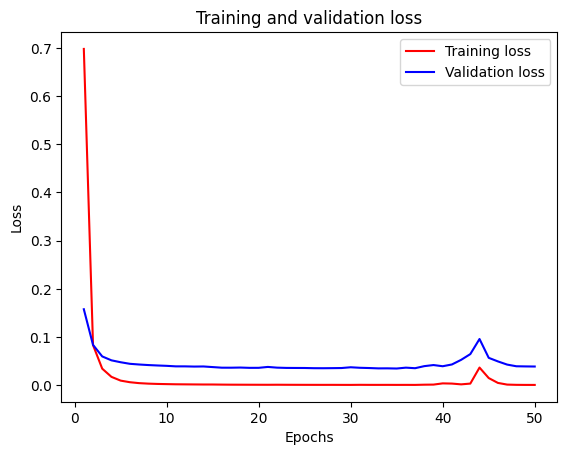

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss',)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluation

Evalute the model on test data.

In [65]:
model.load_weights('classifier_image.weights.h5')

/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
model.evaluate(test_dataset)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0379


[0.038935791701078415, 0.9903333187103271]

Plot confusion matrix.

In [25]:
y_test = []
for _, y in test_dataset:
    y_test.append(np.array(y))
    
y_test = np.concatenate(y_test, axis=0)

2024-11-21 22:30:36.442112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
model.predict(test_dataset).argmax(axis=-1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([7, 2, 7, ..., 8, 8, 7])

In [28]:
y_pred = model.predict(test_dataset).argmax(axis=-1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [66]:
labels = ["Among Us", "Apex Legends", "Fortnite", "Forza Horizon", "Free Fire",
          "Genshin Impact", "God of War", "Minecraft", "Roblox", "Terraria"]

In [45]:
_, ax = plt.subplots(figsize=(8, 12))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, ax=ax, colorbar=False)
plt.xticks(rotation=45)
plt.show()

In [67]:
base_dir = 'gameplay_images/'

class_folders = [x for x in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, x))]

all_photos = []

for class_folder in class_folders:
    class_path = os.path.join(base_dir, class_folder)
    photos = [os.path.join(class_folder, x) for x in os.listdir(class_path)]
    all_photos.extend(photos)

random_photos = random.sample(all_photos, 4)

for photo in random_photos:
    print(f"Фото: {photo}, Класс: {os.path.dirname(photo)}")

Фото: Roblox/8201.jpg, Класс: Roblox
Фото: Free Fire/4307.jpg, Класс: Free Fire
Фото: Free Fire/4679.jpg, Класс: Free Fire
Фото: Genshin Impact/5152.jpg, Класс: Genshin Impact


In [68]:
backbone = transformers.AutoModel.from_pretrained('facebook/dinov2-small')
processor = transformers.AutoImageProcessor.from_pretrained('facebook/dinov2-small')

In [73]:
def extract_features(image_path):
    image = Image.open(os.path.join(base_dir, image_path)).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")
    features = backbone(**inputs).pooler_output.detach().numpy()
    return features

predictions = []
for photo in random_photos:
    features = extract_features(photo)
    prediction = model.predict(features)
    predicted_class = labels[np.argmax(prediction, axis=1)[0]]
    true_class = os.path.dirname(photo)
    predictions.append((photo, true_class, predicted_class))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [74]:
predictions

[('Roblox/8201.jpg', 'Roblox', 'Roblox'),
 ('Free Fire/4307.jpg', 'Free Fire', 'Free Fire'),
 ('Free Fire/4679.jpg', 'Free Fire', 'Free Fire'),
 ('Genshin Impact/5152.jpg', 'Genshin Impact', 'Genshin Impact')]

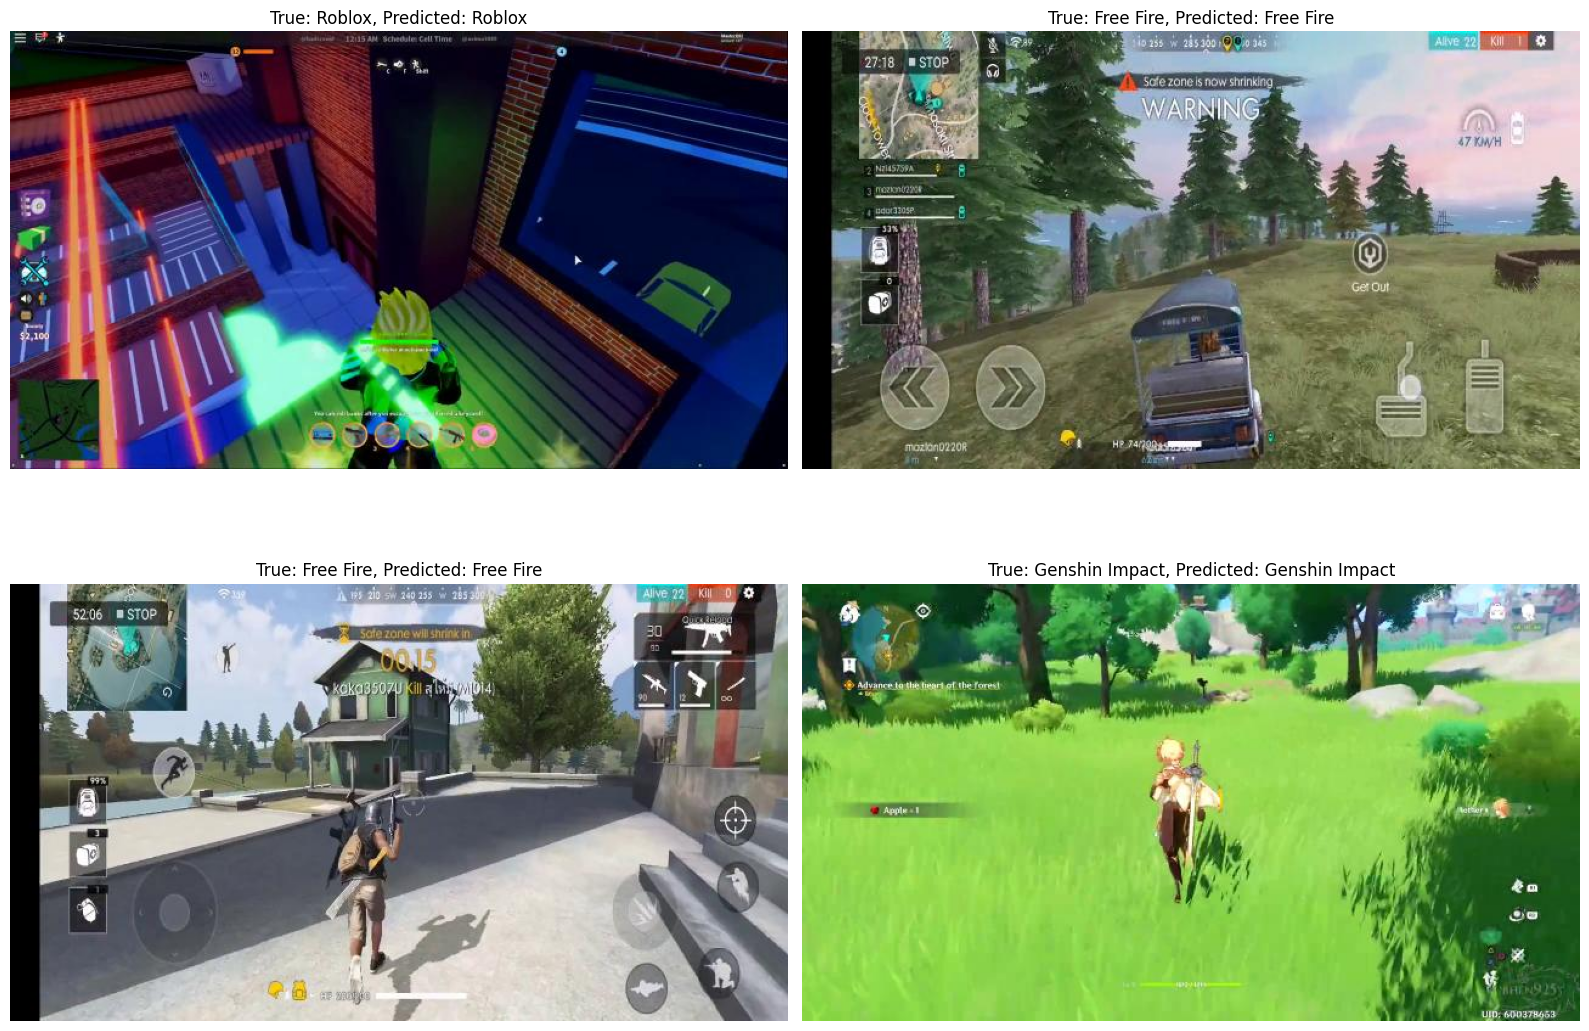

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(16,12))
axes = axes.flatten()
for i, (photo, true_class, predicted_class) in enumerate(predictions):
    image = Image.open(os.path.join(base_dir, photo)).convert('RGB')
    axes[i].imshow(image)
    axes[i].set_title(f"True: {true_class}, Predicted: {predicted_class}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [84]:
base_dir = 'gameplay_images/'

class_folders = [x for x in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, x))]

all_photos = []

for class_folder in class_folders:
    class_path = os.path.join(base_dir, class_folder)
    photos = [os.path.join(class_folder, x) for x in os.listdir(class_path)]
    all_photos.extend(photos)

random_photos1 = random.sample(all_photos, 4)

for photo in random_photos1:
    print(f"Фото: {photo}, Класс: {os.path.dirname(photo)}")

Фото: Fortnite/2113.jpg, Класс: Fortnite
Фото: Minecraft/7262.jpg, Класс: Minecraft
Фото: Forza Horizon/3987.jpg, Класс: Forza Horizon
Фото: Terraria/9972.jpg, Класс: Terraria


In [85]:
predictions1 = []
for photo in random_photos1:
    features = extract_features(photo)
    prediction = model.predict(features)
    predicted_class = labels[np.argmax(prediction, axis=1)[0]]
    true_class = os.path.dirname(photo)
    predictions1.append((photo, true_class, predicted_class))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


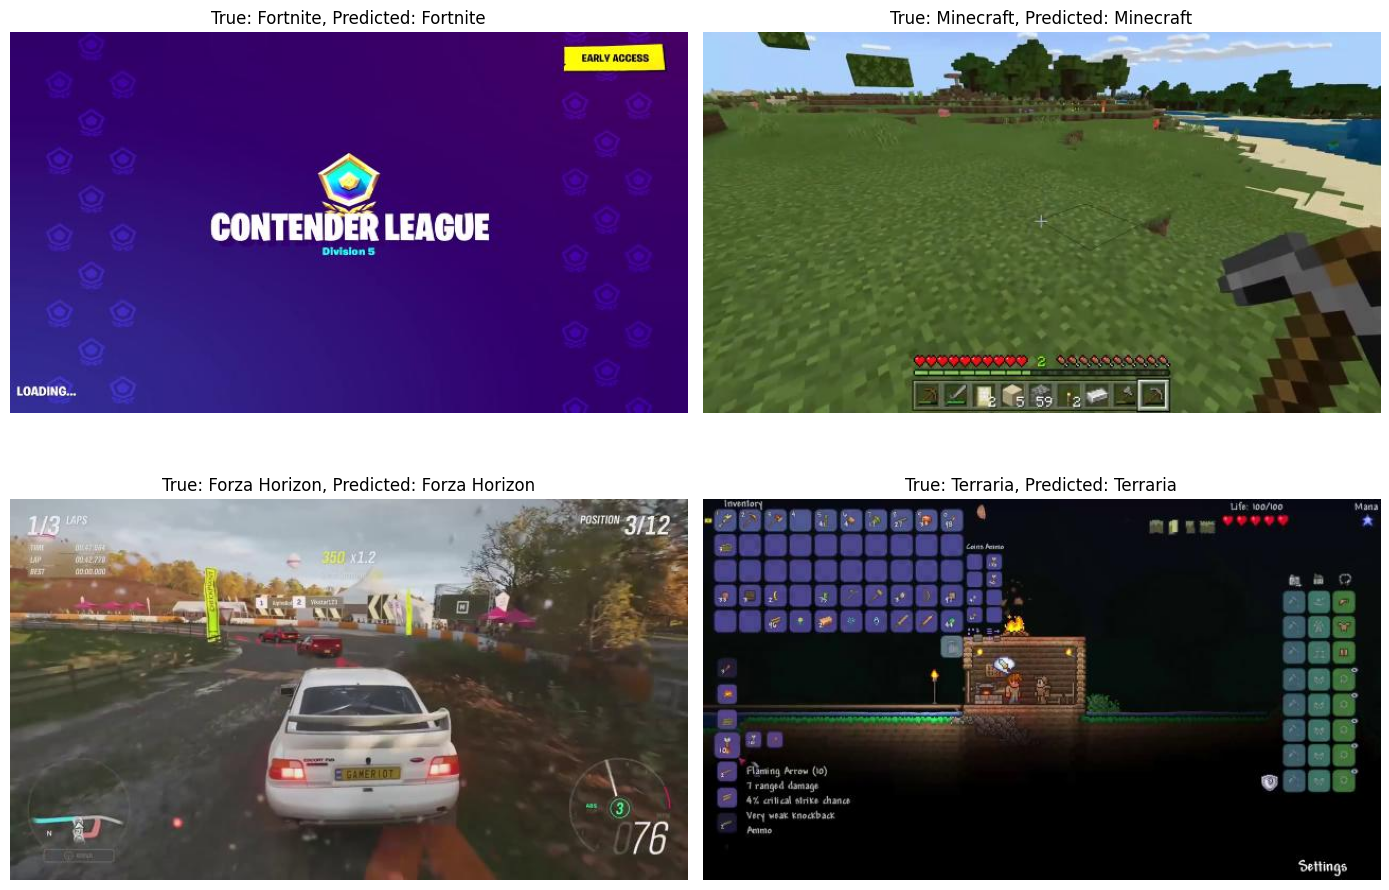

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()
for i, (photo, true_class, predicted_class) in enumerate(predictions1):
    image = Image.open(os.path.join(base_dir, photo)).convert('RGB')
    axes[i].imshow(image)
    axes[i].set_title(f"True: {true_class}, Predicted: {predicted_class}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

Perform dimensiality reduction and plot the extracted features. Do classes form clusters?

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(X_train)

In [59]:
tsne_results.shape

(7000, 2)

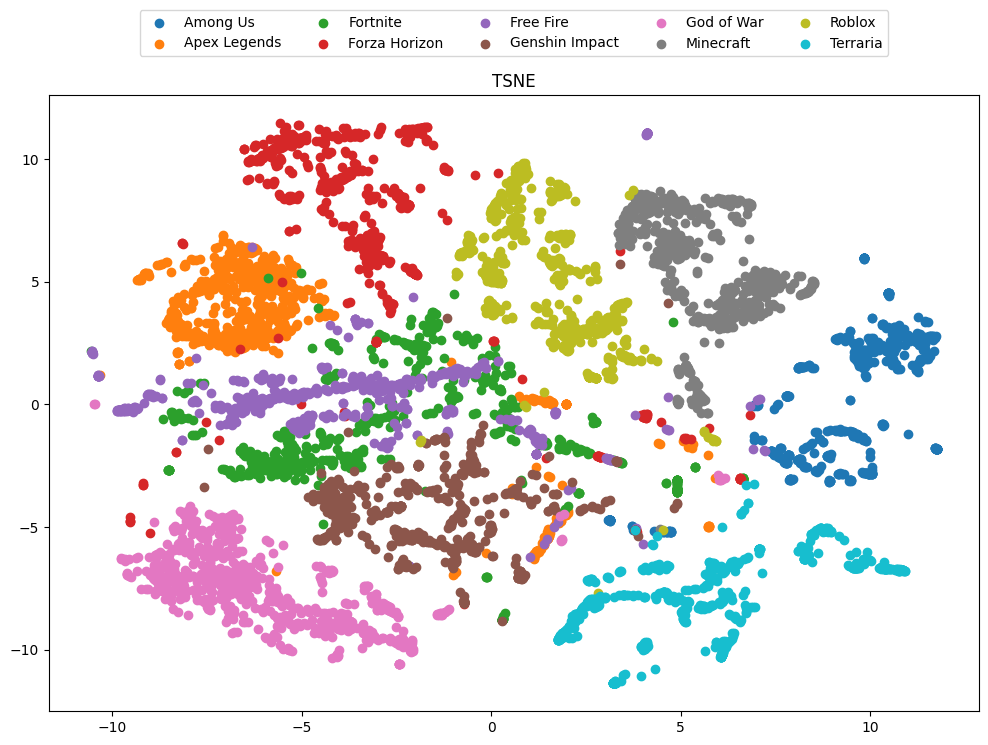

In [83]:
plt.figure(figsize=(12,8))
for i in range(len(labels)):
    plt.scatter(tsne_results[y_train == i, 0], tsne_results[y_train == i, 1], label=labels[i], color=plt.cm.tab10(i))
    
plt.title('TSNE')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)
plt.show()

# Bonus

Check if the feature extractor model can be used without a classifier layer (how large is the average feature vector similarity inbetween same in different classes)

In [21]:
labels = ["Among Us", "Apex Legends", "Fortnite", "Forza Horizon", "Free Fire",
          "Genshin Impact", "God of War", "Minecraft", "Roblox", "Terraria"]

In [60]:
from sklearn.metrics.pairwise import cosine_distances

cosine_distance = cosine_distances(all_features)

mean_cosine_distances = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        if i != j:
            mask1 = (all_labels == i)
            mask2 = (all_labels == j)
            mean_cosine_distances[i, j] = np.mean(cosine_distance[mask1][:, mask2])

for i in range(10):
    print('-'*30)
    print(f'Средние коссинусные расстояние для класса {labels[i]} до других классов:')
    print(mean_cosine_distances[i])
    print('Среднее средних расстояний этого класса до других:')
    print(mean_cosine_distances[i][mean_cosine_distances[i] != 0.0].mean())

------------------------------
Средние коссинусные расстояние для класса Among Us до других классов:
[0.         0.68804419 0.70278007 0.83482057 0.66820294 0.76808989
 0.90757835 0.66666609 0.72621477 0.58300519]
Среднее средних расстояний этого класса до других:
0.727266894446479
------------------------------
Средние коссинусные расстояние для класса Apex Legends до других классов:
[0.68804401 0.         0.68300223 0.79618865 0.6416589  0.71934998
 0.81055361 0.6930148  0.67461693 0.6908263 ]
Среднее средних расстояний этого класса до других:
0.7108061578538682
------------------------------
Средние коссинусные расстояние для класса Fortnite до других классов:
[0.70278025 0.68300229 0.         0.83151901 0.65659076 0.68857151
 0.82313621 0.706936   0.70041502 0.67994136]
Среднее средних расстояний этого класса до других:
0.7192102670669556
------------------------------
Средние коссинусные расстояние для класса Forza Horizon до других классов:
[0.83482099 0.79618865 0.83151913 0.   

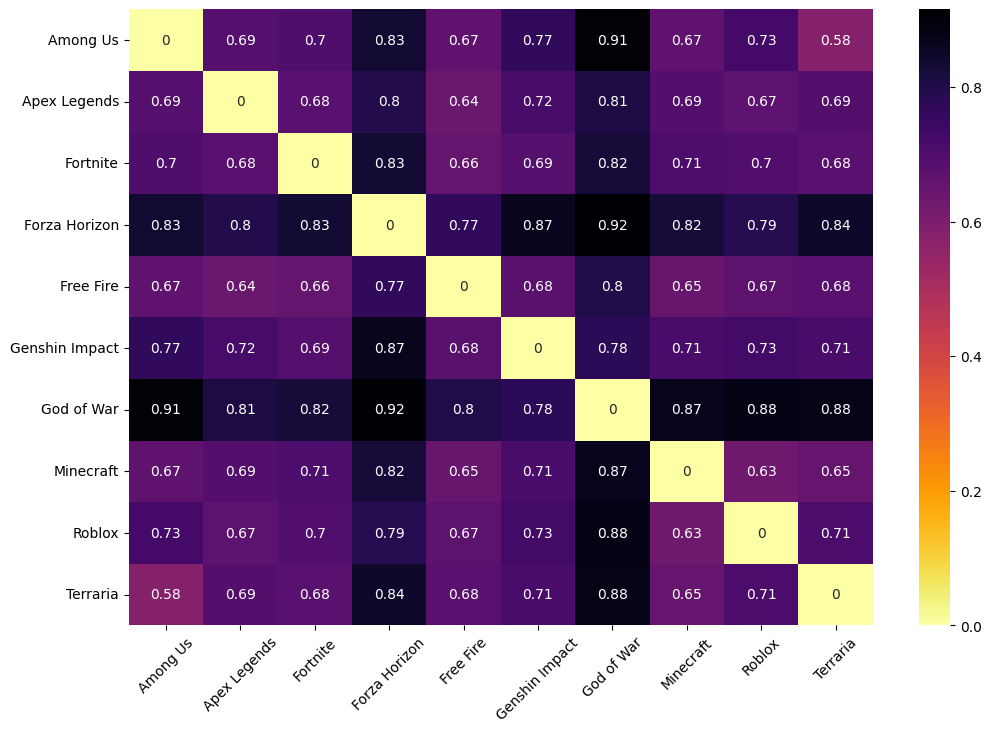

In [61]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(mean_cosine_distances, annot=True, xticklabels=labels, yticklabels=labels, cmap=plt.cm.inferno_r)
plt.xticks(rotation=45)
plt.show()